# Análise para departamento de vendas
Objetivo: Predizer vendas para um período futuro
## Importação de bibliotecas e carga de dados

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from prophet import Prophet

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_680/3165533024.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [13]:
sales_train_df = pd.read_csv("./train.csv")
sales_train_df

/tmp/ipykernel_680/2427131367.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_train_df = pd.read_csv("./train.csv")


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [14]:
store_info_df = pd.read_csv("./store.csv")
store_info_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


CompetitionDistance: Distância até a loja concorrent <br>
CompetitionOpenSinceMonth e CompetitionOpenSinceYear: Mês e ano de abertura da loja concorrente <br>
Promo2: Promoção adicional <br>
Promo2SinceWeek e Promo2SinceYear: Semana e ano da promoção adicional <br>

## Análise dos dados

In [15]:
sales_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [16]:
sales_train_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [17]:
store_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [18]:
store_info_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


### Analisando o sales_train_df

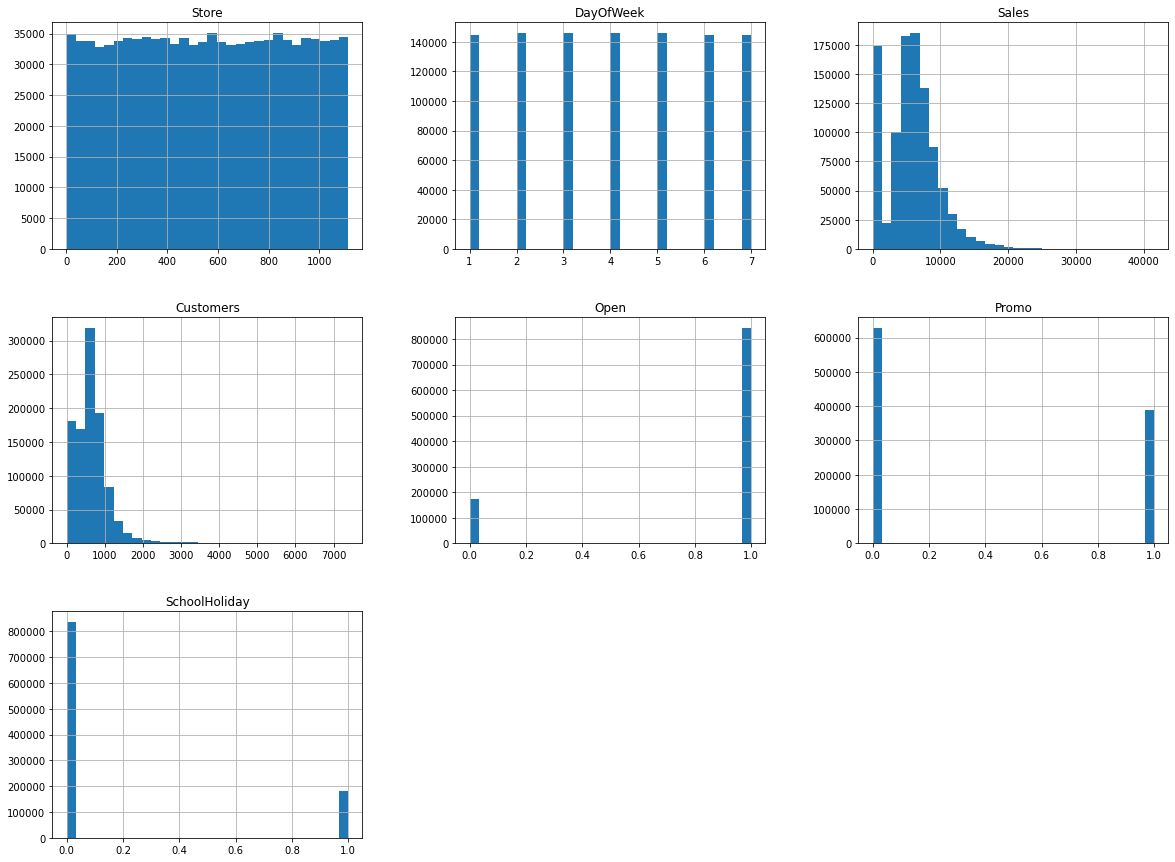

In [19]:
sales_train_df.hist(bins=30, figsize=(20, 15));

In [20]:
opened_df = sales_train_df.query("Open == 1")
closened_df = sales_train_df.query("Open == 0")

print("lojas/dias aberto:", len(opened_df))
print("lojas/dias fechado:", len(closened_df))

lojas/dias aberto: 844392
lojas/dias fechado: 172817


Quando a loja está fechada, ela tem importância para a análise, então será retirado do dado esses registros

In [21]:
sales_train_df = opened_df
sales_train_df.drop(columns=["Open"], inplace=True)

sales_train_df

/tmp/ipykernel_680/2755159792.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_train_df.drop(columns=["Open"], inplace=True)


,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,0,1
1,2,5,2015-07-31,6064,625,1,0,1
2,3,5,2015-07-31,8314,821,1,0,1
3,4,5,2015-07-31,13995,1498,1,0,1
4,5,5,2015-07-31,4822,559,1,0,1
...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,0,a,1
1016827,733,2,2013-01-01,10765,2377,0,a,1
1016863,769,2,2013-01-01,5035,1248,0,a,1
1017042,948,2,2013-01-01,4491,1039,0,a,1


In [22]:
sales_train_df.describe()

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000
mean,558.422920,3.520361,6955.514291,762.728395,0.446352,0.193580
std,321.731914,1.723689,3104.214680,401.227674,0.497114,0.395103
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,4859.000000,519.000000,0.000000,0.000000
50%,558.000000,3.000000,6369.000000,676.000000,0.000000,0.000000
75%,837.000000,5.000000,8360.000000,893.000000,1.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000


### Analisando o store_info_df

<AxesSubplot:>

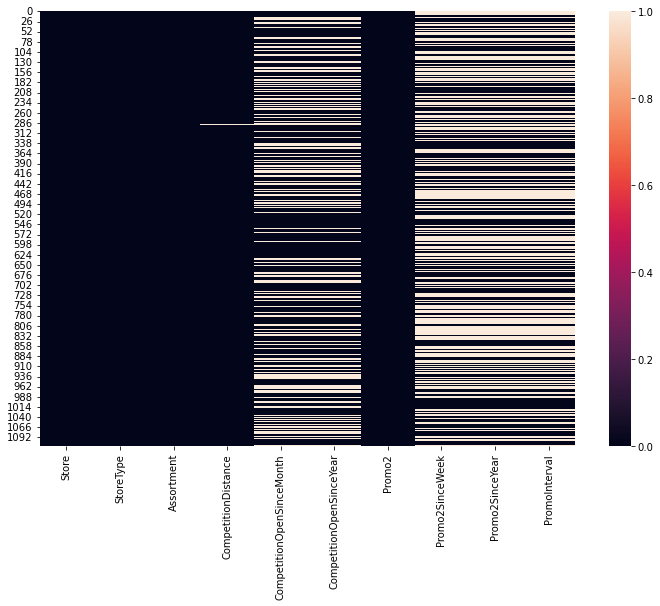

In [23]:
plt.figure(figsize=(12, 8))
sns.heatmap(store_info_df.isnull())

In [24]:
store_info_df.query("CompetitionDistance.isnull()")

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [25]:
store_info_df.query("CompetitionOpenSinceMonth.isnull()")

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [26]:
store_info_df.query("CompetitionOpenSinceYear.isnull()")

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


Se o atributo CompetitionOpenSinceMonth não está preenchido, o CompetitionOpenSinceYear também não está

In [27]:
store_info_df.query("Promo2 == 0")

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


Quando o Promo2=0, não faria sentido existir os atributos Promo2SinceWeek, Promo2SinceYear e PromoInterval

Inserindo 0 para os atributos Promo2SinceWeek, Promo2SinceYear, PromoInterval, CompetitionOpenSinceMonth e CompetitionOpenSinceYear para preencher os valores faltantes

In [28]:
cols_to_fill = ["Promo2SinceWeek", "Promo2SinceYear", "PromoInterval", "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]
store_info_df[cols_to_fill] = store_info_df[cols_to_fill].fillna(0)

Inserindo a média do atributo CompetitionDistance para preencher os valores faltantes desta coluna

In [29]:
store_info_df["CompetitionDistance"].fillna(store_info_df["CompetitionDistance"].mean(), inplace=True)

In [30]:
store_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   float64
 5   CompetitionOpenSinceYear   1115 non-null   float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            1115 non-null   float64
 8   Promo2SinceYear            1115 non-null   float64
 9   PromoInterval              1115 non-null   object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


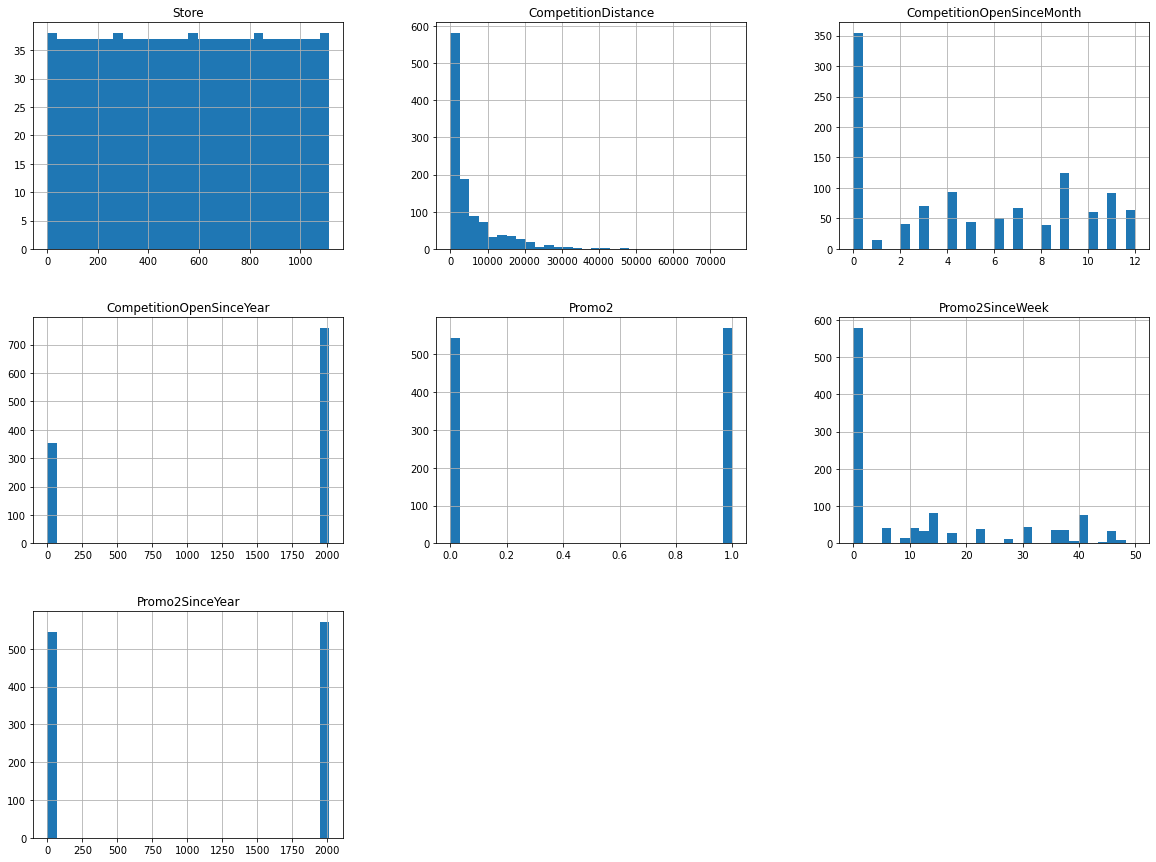

In [31]:
store_info_df.hist(bins=30, figsize=(20, 15));

### União os dois conjuntos de dados

In [32]:
sales_df = store_info_df.merge(sales_train_df, on="Store")

sales_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,5,2015-07-31,5263,555,1,0,1
1,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,4,2015-07-30,5020,546,1,0,1
2,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,3,2015-07-29,4782,523,1,0,1
3,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2,2015-07-28,5011,560,1,0,1
4,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,1,2015-07-27,6102,612,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,1115,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",1,2013-01-07,6905,471,1,0,1
844388,1115,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",6,2013-01-05,4771,339,0,0,1
844389,1115,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",5,2013-01-04,4540,326,0,0,1
844390,1115,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",4,2013-01-03,4297,300,0,0,1


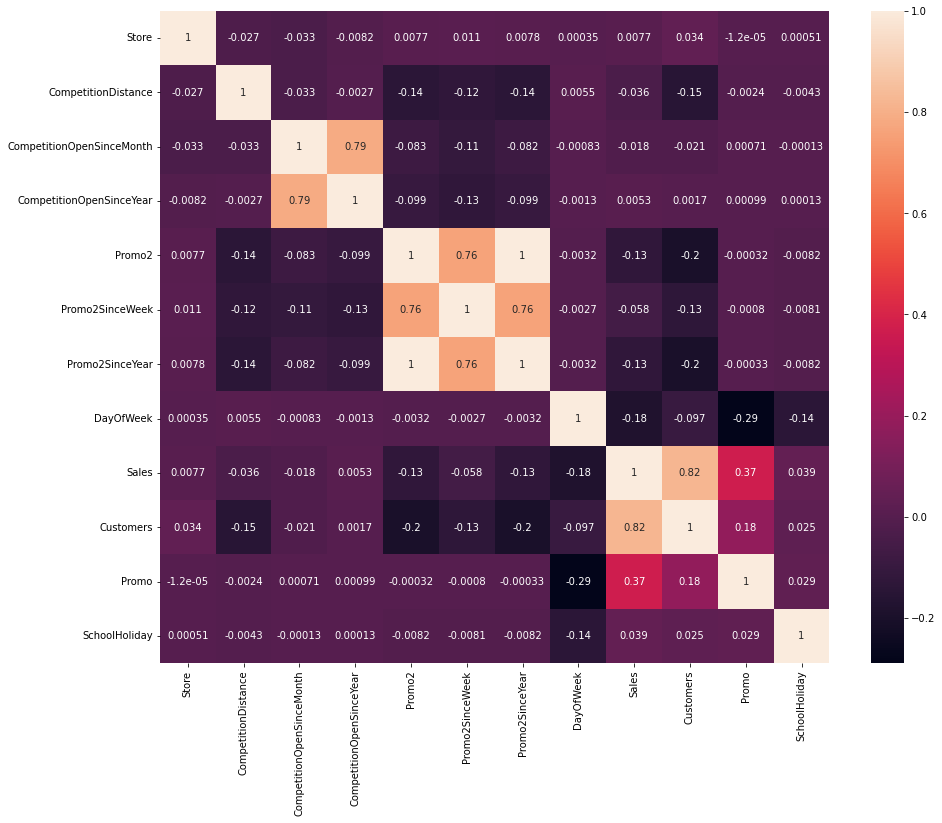

In [33]:
corr = sales_df.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr, annot=True);

### Análise temporal

In [34]:
sales_df['Date'] = pd.to_datetime(sales_df['Date'])
sales_df['Day'] = sales_df['Date'].apply(lambda x: x.day)
sales_df['Month'] = sales_df['Date'].apply(lambda x: x.month)
sales_df['Year'] = sales_df['Date'].apply(lambda x: x.year)

sales_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Day,Month,Year
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,5,2015-07-31,5263,555,1,0,1,31,7,2015
1,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,4,2015-07-30,5020,546,1,0,1,30,7,2015
2,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,3,2015-07-29,4782,523,1,0,1,29,7,2015
3,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2,2015-07-28,5011,560,1,0,1,28,7,2015
4,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,1,2015-07-27,6102,612,1,0,1,27,7,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,1115,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",1,2013-01-07,6905,471,1,0,1,7,1,2013
844388,1115,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",6,2013-01-05,4771,339,0,0,1,5,1,2013
844389,1115,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",5,2013-01-04,4540,326,0,0,1,4,1,2013
844390,1115,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",4,2013-01-03,4297,300,0,0,1,3,1,2013


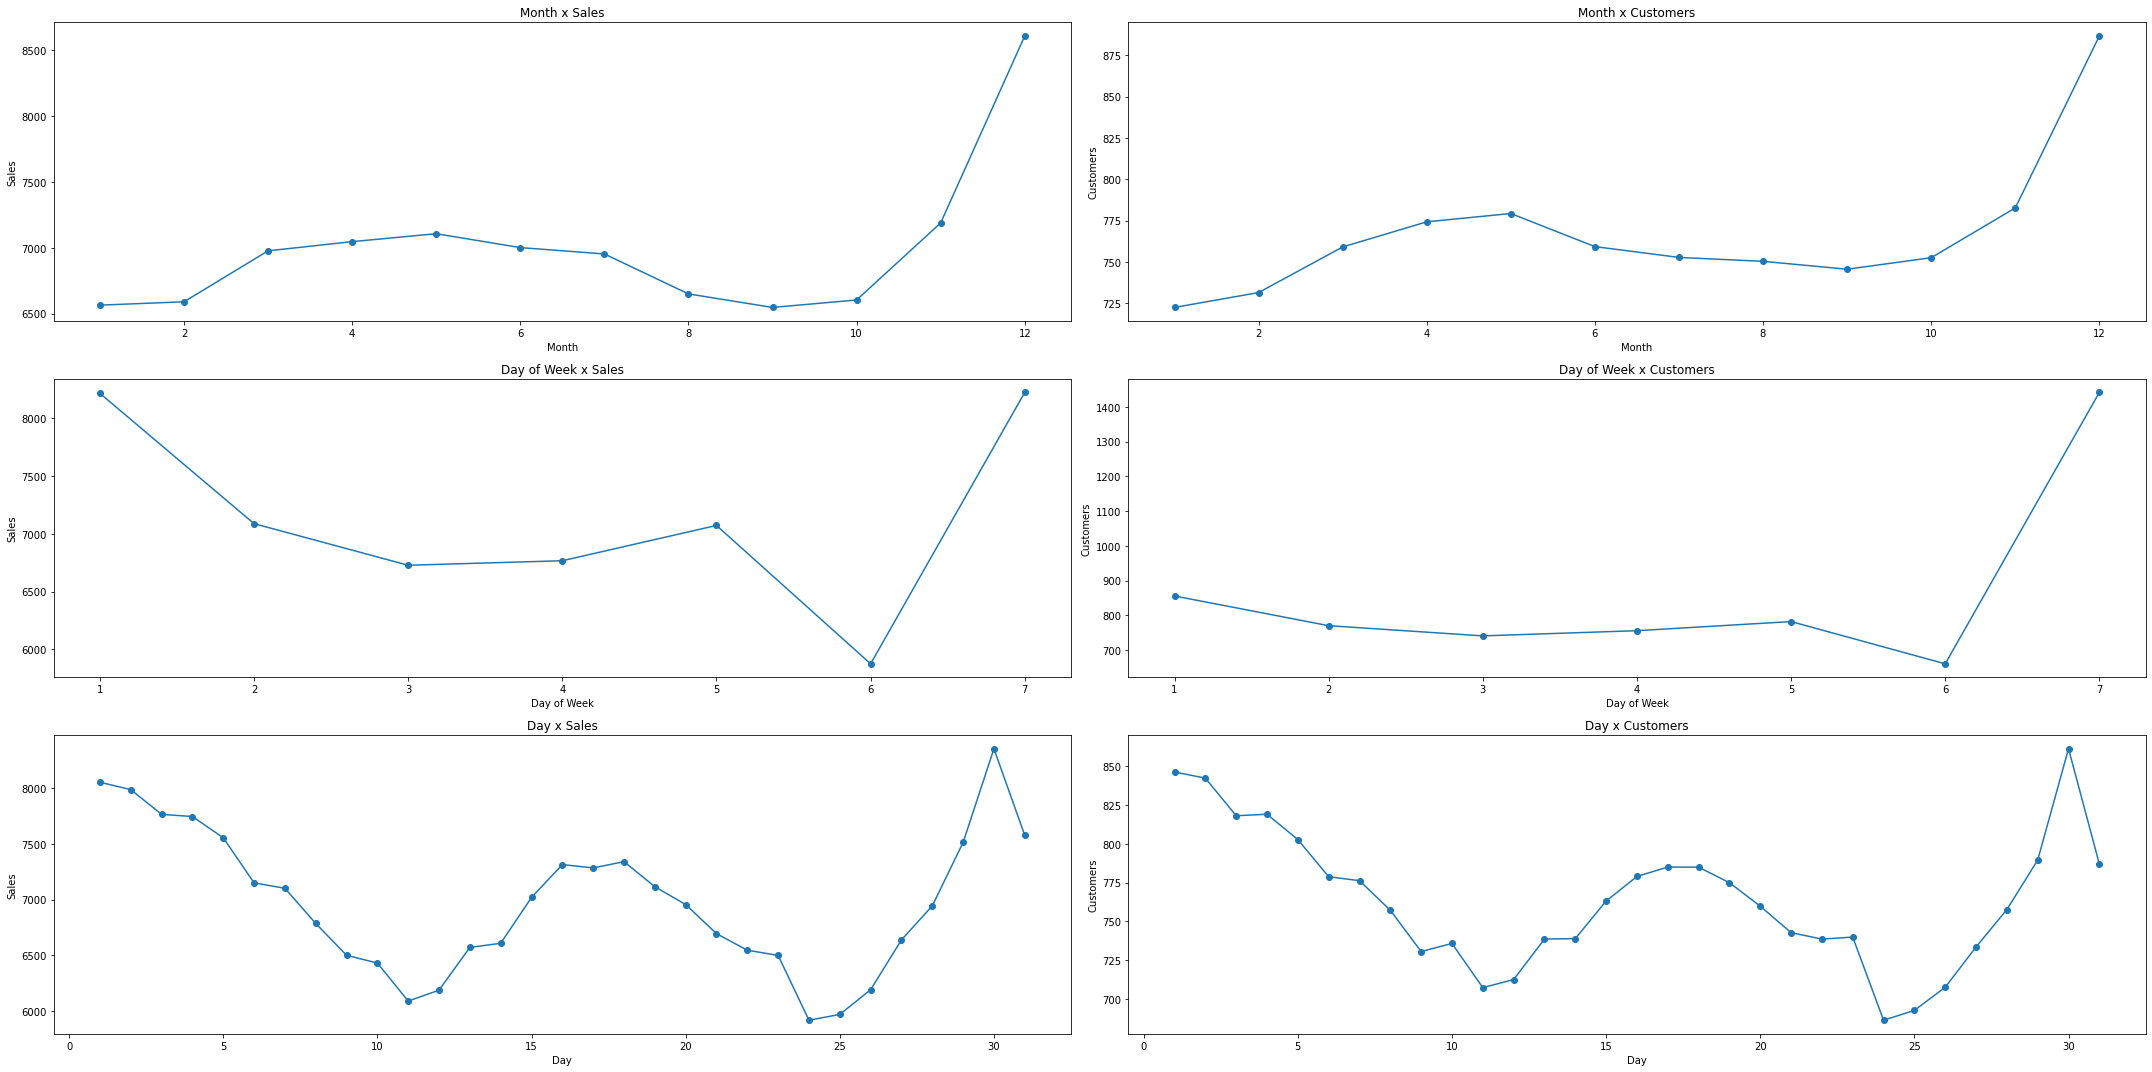

In [56]:
sales_month = sales_df.groupby(by="Month")[["Sales"]].mean()
customers_month = sales_df.groupby(by="Month")[["Customers"]].mean()
sales_days = sales_df.groupby(by="Day")[["Sales"]].mean()
customers_days = sales_df.groupby(by="Day")[["Customers"]].mean()
sales_weekdays = sales_df.groupby(by="DayOfWeek")[["Sales"]].mean()
customers_weekdays = sales_df.groupby(by="DayOfWeek")[["Customers"]].mean()

plt.figure(figsize=(30, 15))
plt.subplot(3, 2, 1)
plt.plot(sales_month.index, sales_month.Sales, "o-")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.title("Month x Sales")

plt.subplot(3, 2, 2)
plt.plot(customers_month.index, customers_month.Customers, "o-")
plt.xlabel("Month")
plt.ylabel("Customers")
plt.title("Month x Customers");

plt.subplot(3, 2, 3)
plt.plot(sales_weekdays.index, sales_weekdays.Sales, "o-")
plt.xlabel("Day of Week")
plt.ylabel("Sales")
plt.title("Day of Week x Sales");

plt.subplot(3, 2, 4)
plt.plot(customers_weekdays.index, customers_weekdays.Customers, "o-")
plt.xlabel("Day of Week")
plt.ylabel("Customers")
plt.title("Day of Week x Customers");

plt.subplot(3, 2, 5)
plt.plot(sales_days.index, sales_days.Sales, "o-")
plt.xlabel("Day")
plt.ylabel("Sales")
plt.title("Day x Sales");

plt.subplot(3, 2, 6)
plt.plot(customers_days.index, customers_days.Customers, "o-")
plt.xlabel("Day")
plt.ylabel("Customers")
plt.title("Day x Customers");

plt.tight_layout()

MES 1


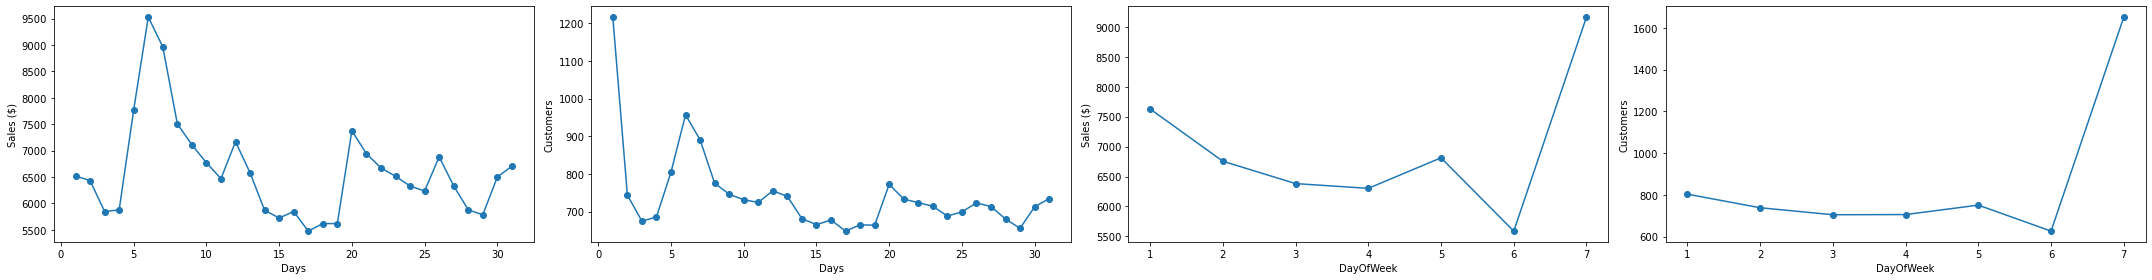

MES 2


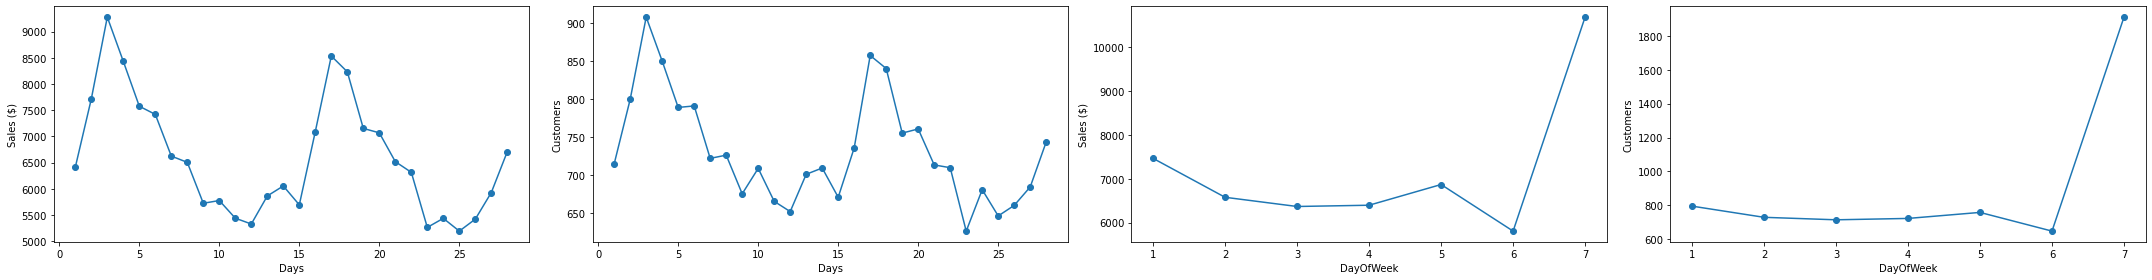

MES 3


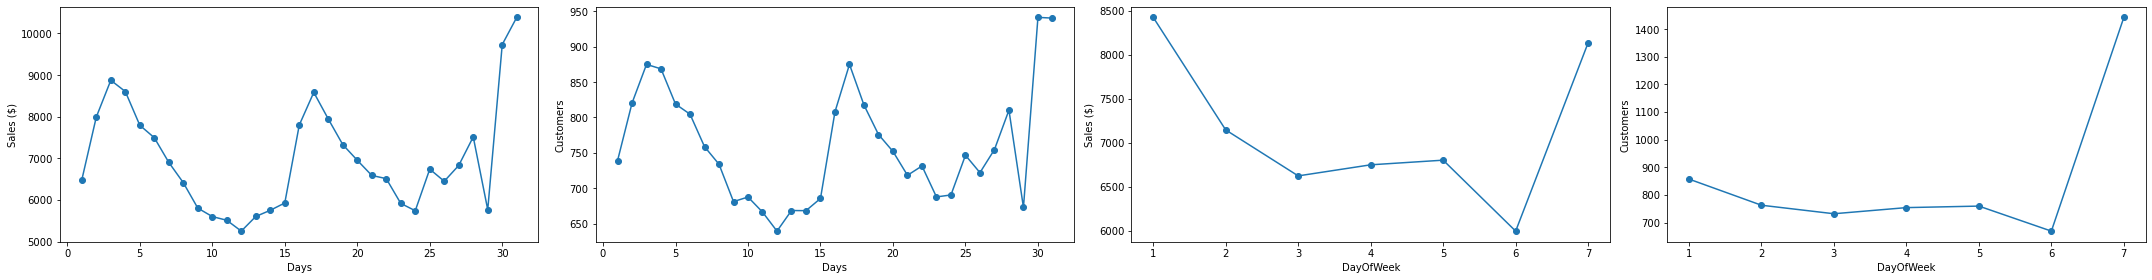

MES 4


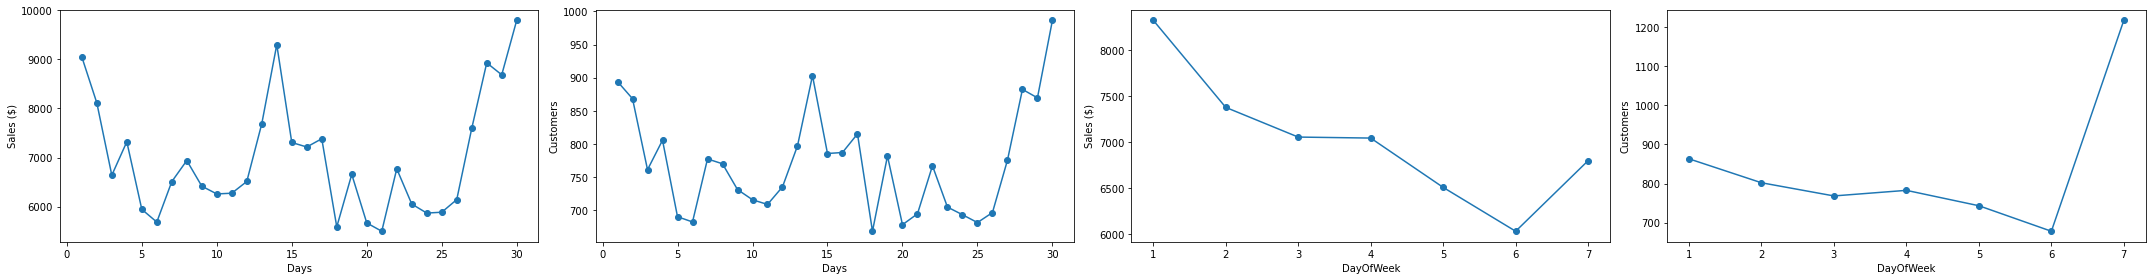

MES 5


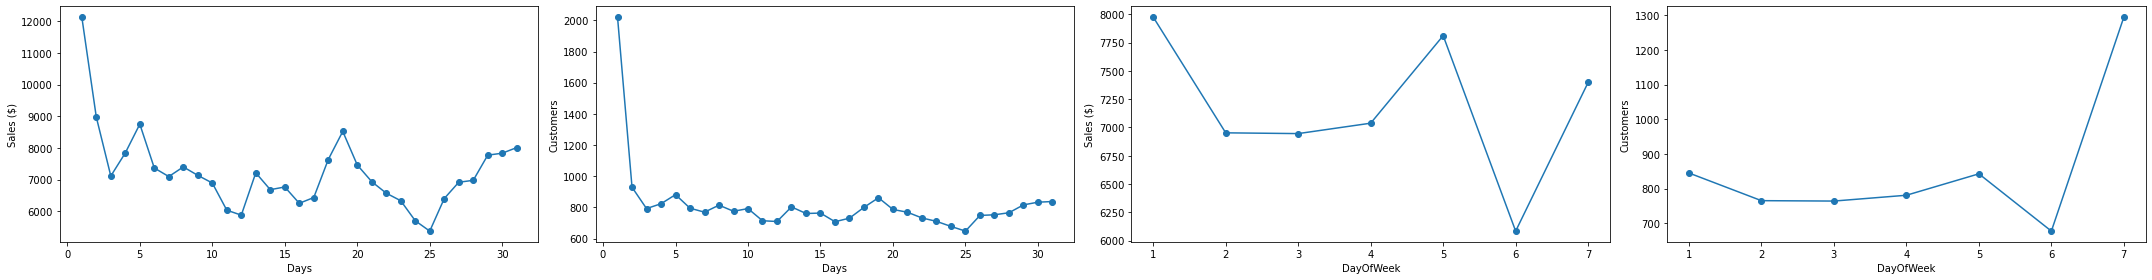

MES 6


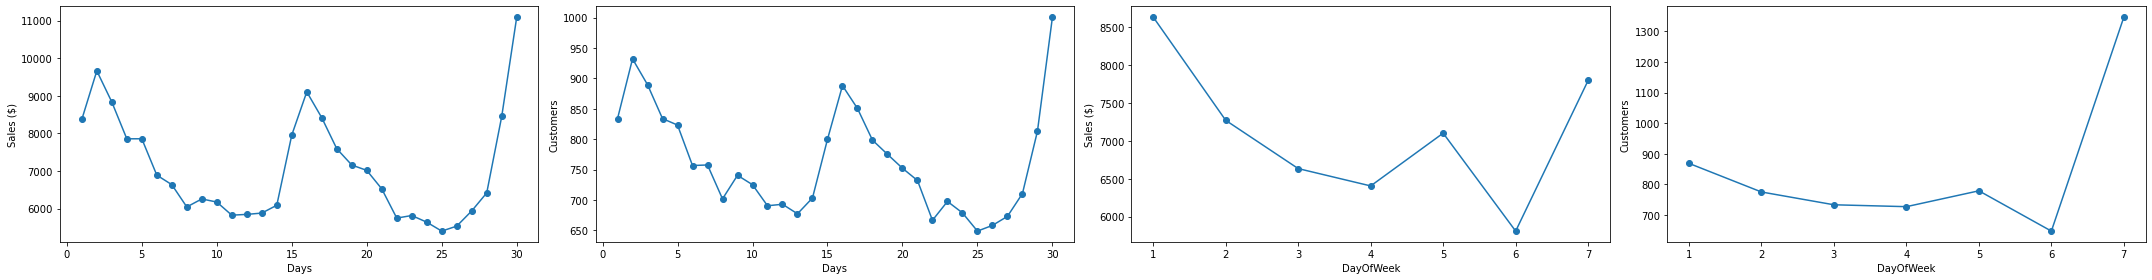

MES 7


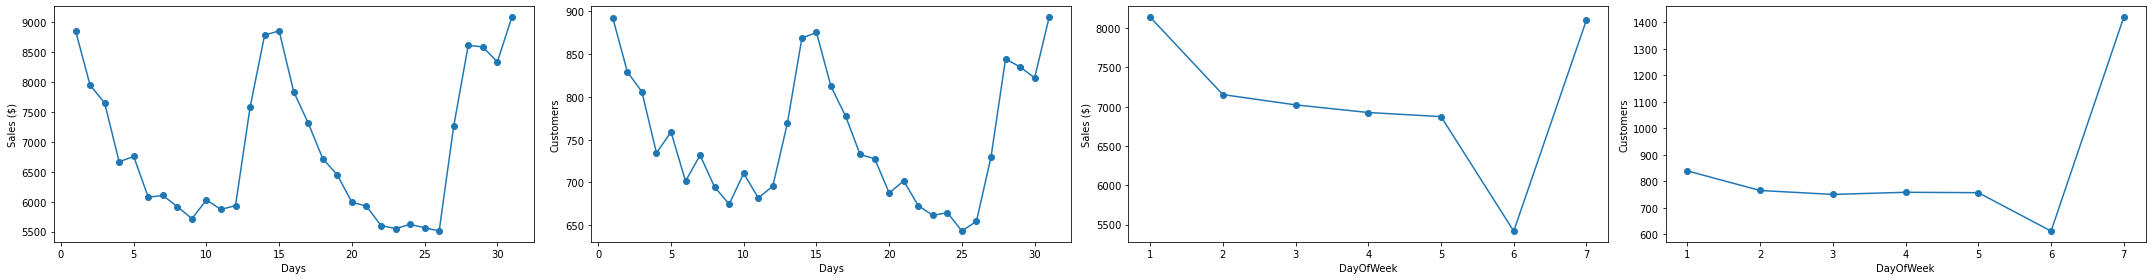

MES 8


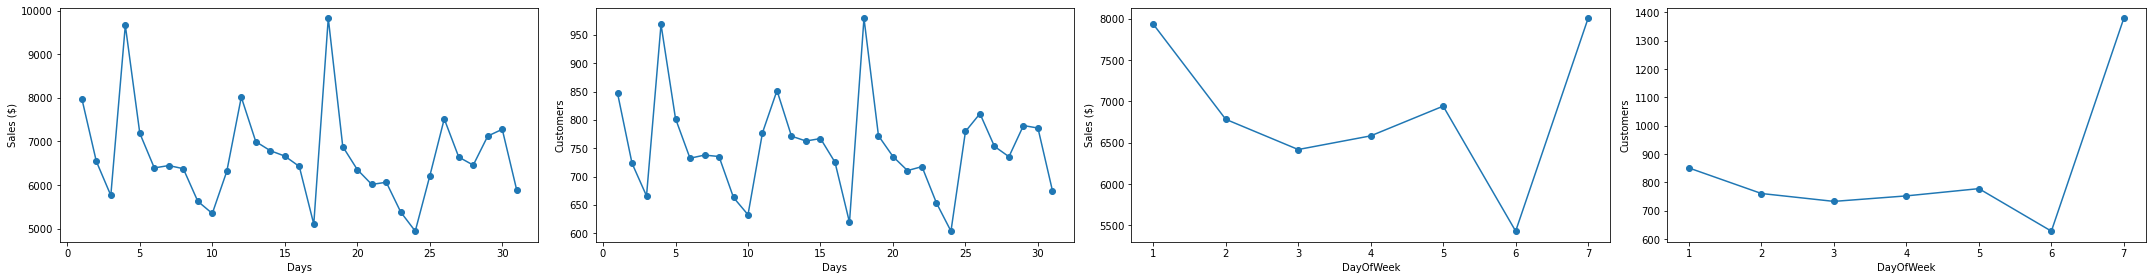

MES 9


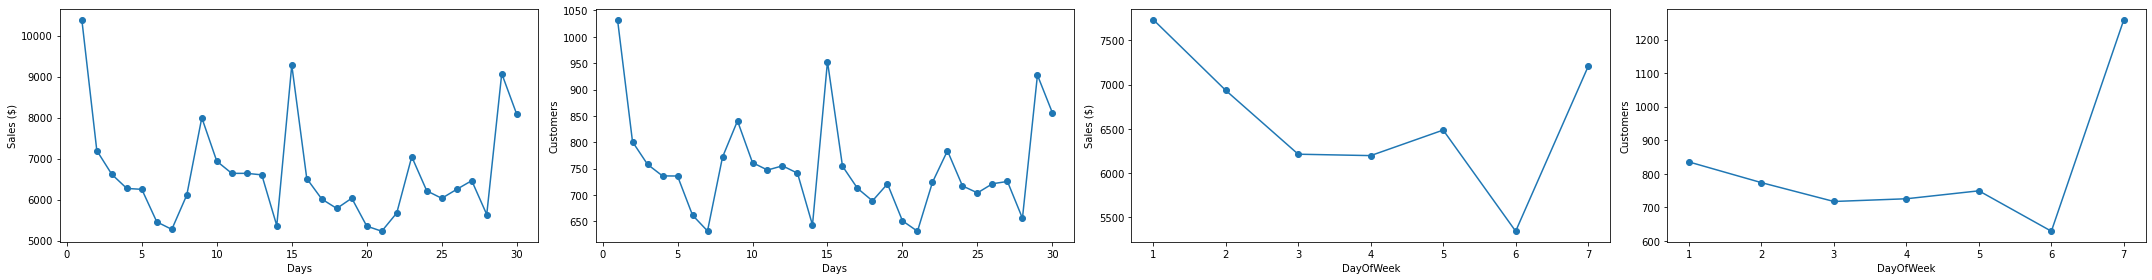

MES 10


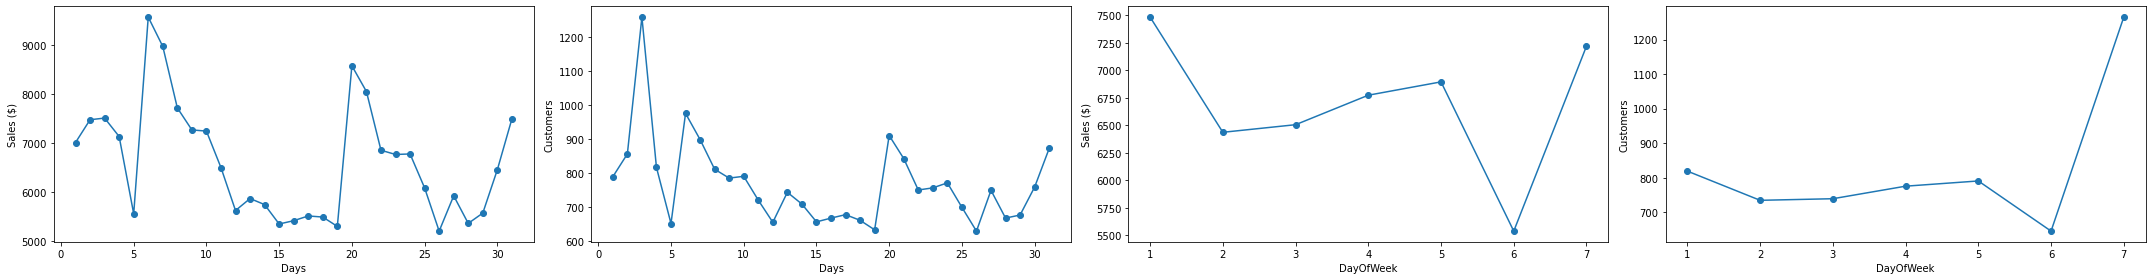

MES 11


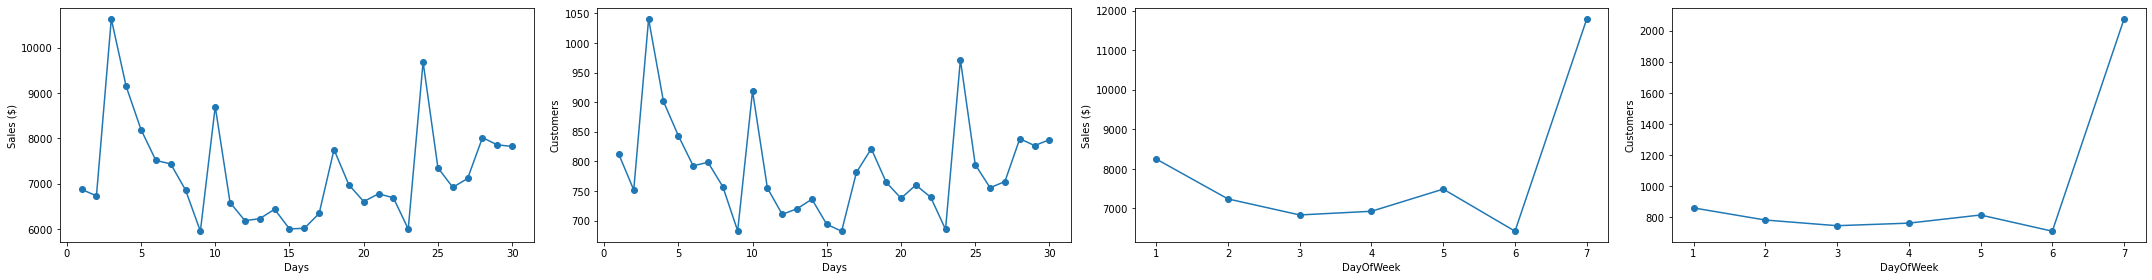

MES 12


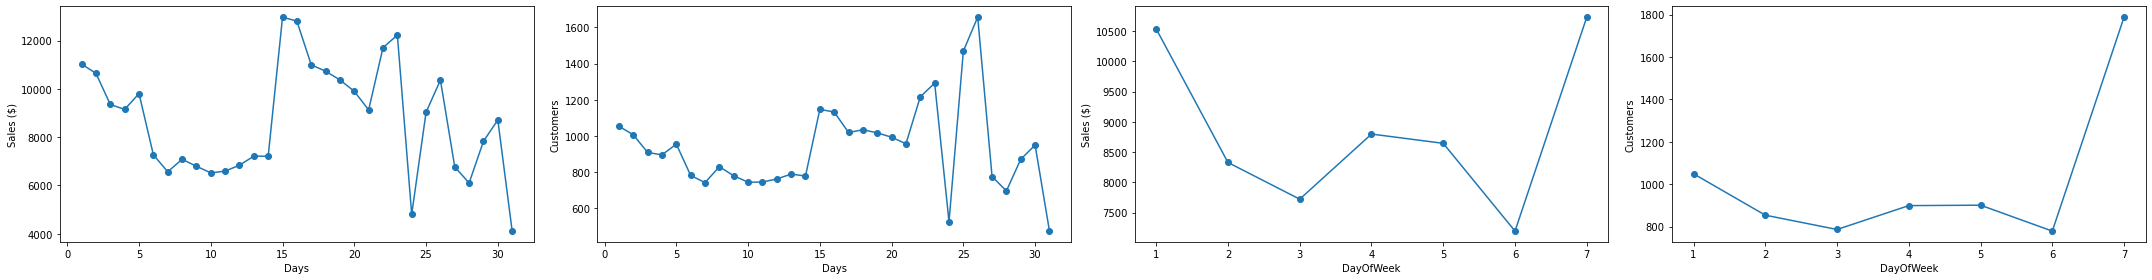

In [57]:
for month in range(1, 13):
    print("MES", month)
    plt.figure(figsize=(30, 4))
    sales_days = sales_df.query(f"Month == {month}").groupby(by="Day")[["Sales"]].mean()
    plt.subplot(1, 4, 1)
    plt.plot(sales_days.index, sales_days.Sales, "o-")
    plt.xlabel("Days")
    plt.ylabel("Sales ($)")
    
    customers_days = sales_df.query(f"Month == {month}").groupby(by="Day").mean()[["Customers"]]
    plt.subplot(1, 4, 2)
    plt.plot(customers_days.index, customers_days.Customers, "o-")
    plt.xlabel("Days")
    plt.ylabel("Customers")
    
    sales_weekdays = sales_df.query(f"Month == {month}").groupby(by="DayOfWeek")[["Sales"]].mean()
    plt.subplot(1, 4, 3)
    plt.plot(sales_weekdays.index, sales_weekdays.Sales, "o-")
    plt.xlabel("DayOfWeek")
    plt.ylabel("Sales ($)")
    
    customers_weekdays = sales_df.query(f"Month == {month}").groupby(by="DayOfWeek")[["Customers"]].mean()
    plt.subplot(1, 4, 4)
    plt.plot(customers_weekdays.index, customers_weekdays.Customers, "o-")
    plt.xlabel("DayOfWeek")
    plt.ylabel("Customers")
    
    plt.tight_layout()
    plt.show()

<AxesSubplot:xlabel='Date'>

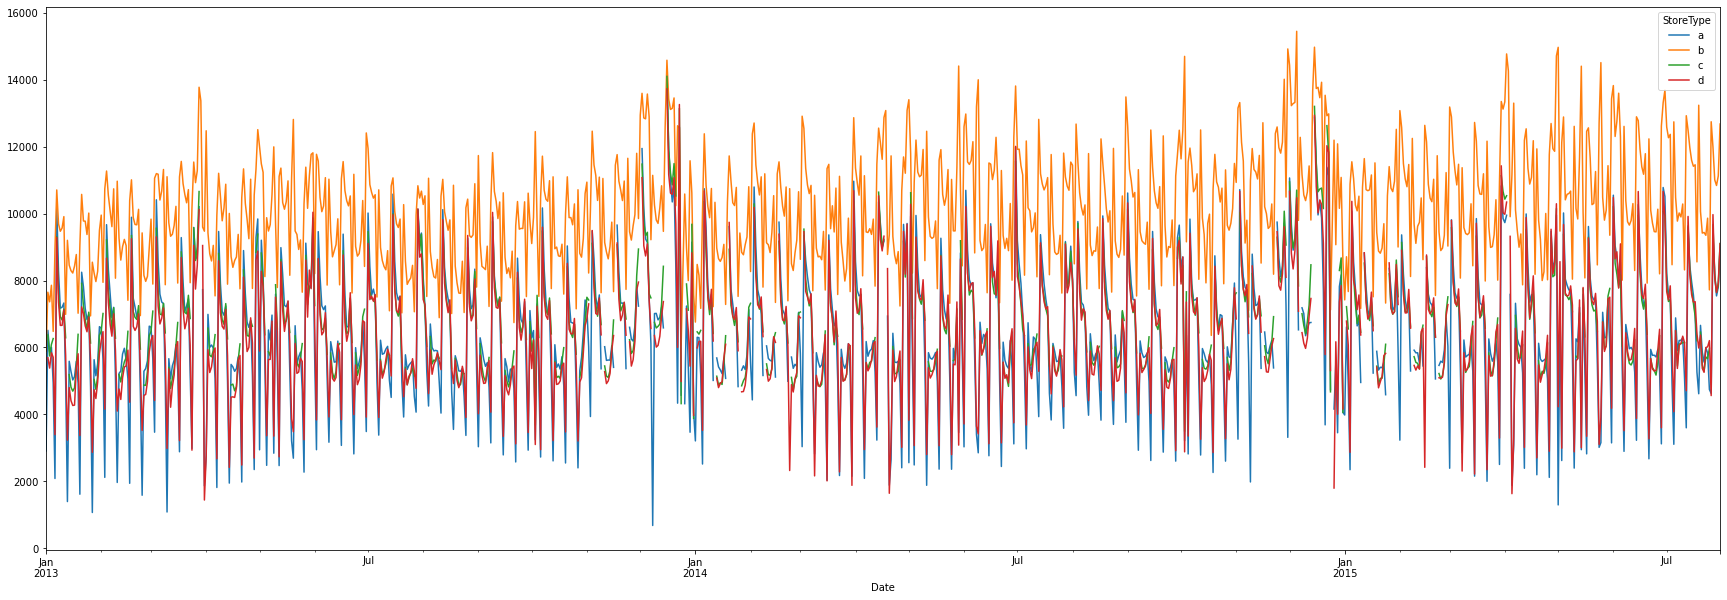

In [25]:
fig, ax = plt.subplots(figsize=(30, 10))
sales_df.groupby(by=["Date", "StoreType"]).mean()["Sales"].unstack().plot(ax=ax)

## Predição da serie temporal com o Prophet

In [55]:
def sales_prediction(store_id: int, sales: pd.DataFrame, holidays: pd.DataFrame, periods: int):
    sales = sales.query(f"Store == {store_id}")[["Date", "Sales"]]
    sales.rename(columns={'Date': 'ds', 'Sales':'y'}, inplace = True)
    sales.sort_values(by="ds", inplace=True)
    
    model = Prophet(holidays=holidays)
    model.fit(sales)
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    figure = model.plot(forecast, xlabel="Data", ylabel="Sales")
    figure2 = model.plot_components(forecast)
    
    return sales, forecast

In [57]:
school_holidays = sales_df.query("SchoolHoliday == 1")["Date"].values
state_holidays = sales_df.query("StateHoliday.isin(['a', 'b', 'c'])")["Date"].values
school_holidays.shape, state_holidays.shape

((163457,), (910,))

In [58]:
school_holidays = pd.DataFrame({"ds": school_holidays, "holiday": "school_holyday"})
state_holidays = pd.DataFrame({"ds": state_holidays, "holiday": "state_holyday"})

holidays_df = pd.concat([school_holidays, state_holidays])
holidays_df.drop_duplicates(inplace=True)
holidays_df

,ds,holiday
0,2015-07-31,school_holyday
1,2015-07-30,school_holyday
2,2015-07-29,school_holyday
3,2015-07-28,school_holyday
4,2015-07-27,school_holyday
...,...,...
239,2014-11-01,state_holyday
250,2013-11-01,state_holyday
265,2015-01-06,state_holyday
277,2014-01-06,state_holyday


Ao final do treinamento, é exibido algumas análises fornecidas pela biblioteca

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/daniel/miniconda3/envs/dissertacao/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/daniel/miniconda3/envs/dissertacao/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.16708
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1535.81   0.000217897       115.633           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       1535.88   0.000225946       87.7254   1.848e-06       0.001      185  LS failed, Hessian reset 
     199       1535.95   1.26121e-06       102.112           1           1      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       1535.95   3.98702e-08        98.114      0.7758      0.7758      276   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/daniel/miniconda3/envs/dissertacao/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/daniel/miniconda3/envs/dissertacao/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/daniel/miniconda3/envs/dissertacao/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


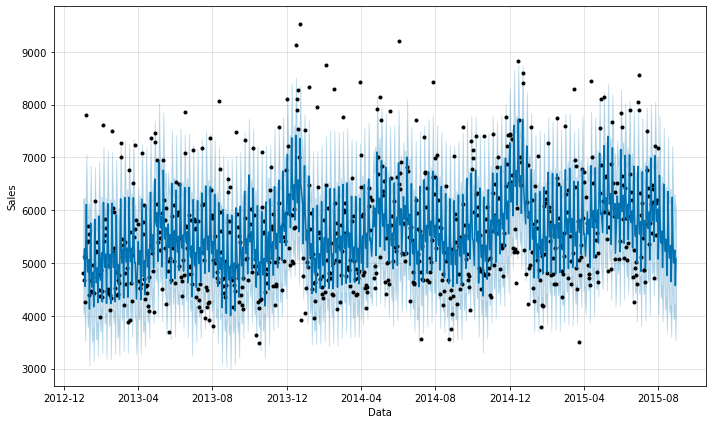

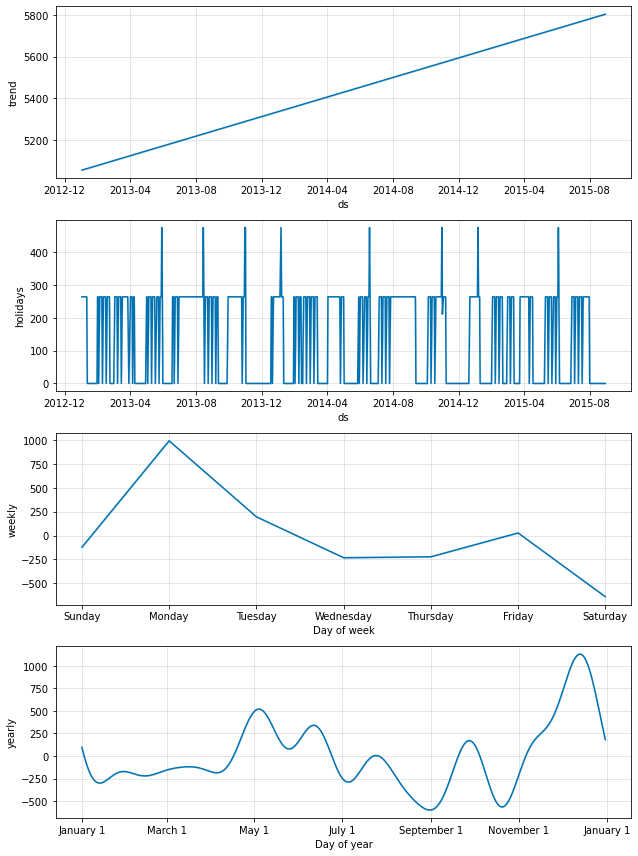

In [59]:
sales, forecast = sales_prediction(10, sales_df, holidays_df, 30)

In [60]:
sales

,ds,y
7819,2013-01-02,4812
7818,2013-01-03,4675
7817,2013-01-04,5114
7816,2013-01-05,4256
7815,2013-01-07,7804
...,...,...
7040,2015-07-27,7212
7039,2015-07-28,6140
7038,2015-07-29,5524
7037,2015-07-30,6186


### Resultado

In [61]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-02,5054.436658,4130.544017,6218.272353,5054.436658,5054.436658,66.586607,66.586607,66.586607,264.325124,...,-231.309134,-231.309134,-231.309134,33.570617,33.570617,33.570617,0.0,0.0,0.0,5121.023265
1,2013-01-03,5055.209278,4024.522527,6116.781169,5055.209278,5055.209278,17.442927,17.442927,17.442927,264.325124,...,-221.867137,-221.867137,-221.867137,-25.015059,-25.015059,-25.015059,0.0,0.0,0.0,5072.652205
2,2013-01-04,5055.981897,4181.487950,6231.085621,5055.981897,5055.981897,213.571886,213.571886,213.571886,264.325124,...,27.577818,27.577818,27.577818,-78.331056,-78.331056,-78.331056,0.0,0.0,0.0,5269.553783
3,2013-01-05,5056.754516,3524.028907,5609.141442,5056.754516,5056.754516,-500.802457,-500.802457,-500.802457,264.325124,...,-639.107876,-639.107876,-639.107876,-126.019705,-126.019705,-126.019705,0.0,0.0,0.0,4555.952059
4,2013-01-07,5058.299754,5036.905033,7057.612737,5058.299754,5058.299754,1051.169511,1051.169511,1051.169511,264.325124,...,990.530088,990.530088,990.530088,-203.685701,-203.685701,-203.685701,0.0,0.0,0.0,6109.469265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809,2015-08-26,5800.787114,3941.385916,6123.795355,5800.787111,5800.787117,-797.831154,-797.831154,-797.831154,0.000000,...,-231.309134,-231.309134,-231.309134,-566.522020,-566.522020,-566.522020,0.0,0.0,0.0,5002.955960
810,2015-08-27,5801.559734,4021.868391,6005.695877,5801.559731,5801.559737,-798.687849,-798.687849,-798.687849,0.000000,...,-221.867137,-221.867137,-221.867137,-576.820712,-576.820712,-576.820712,0.0,0.0,0.0,5002.871885
811,2015-08-28,5802.332354,4220.094781,6297.047671,5802.332350,5802.332357,-557.969190,-557.969190,-557.969190,0.000000,...,27.577818,27.577818,27.577818,-585.547009,-585.547009,-585.547009,0.0,0.0,0.0,5244.363163
812,2015-08-29,5803.104973,3536.889154,5651.635572,5803.104970,5803.104977,-1231.552468,-1231.552468,-1231.552468,0.000000,...,-639.107876,-639.107876,-639.107876,-592.444592,-592.444592,-592.444592,0.0,0.0,0.0,4571.552506


### Salvando o resultado

In [62]:
forecast.tail(30).to_csv("sales_prediction.csv", index=False)